In [1]:
# Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Adjust PATH
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
getwd()

[1] "/projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR"

In [3]:
# Define functions

#' Find Pubmed entries for a topic per year
entrez_pubmed_search_count_by_year <- function(year, term){
    query <- paste(term, "AND (", year, "[PDAT])")
    entrez_search(db="pubmed", term=query, retmax=0)$count
}

#' Search number of complete genomes published per year
entrez_nucleotide_search_count_by_year <- function(year, term) {
    query <- paste(term, "AND (", year, "[PDAT])")
    entrez_search(db="nucleotide", term=query, retmax=0)$count
}

In [23]:
## Define variables

## Input files 
in_tables <- 'docs/supplementary-tables.xlsx'

# Local files
path <- 'data/ncbi_phage-genomes/'
dir.create(path, recursive = TRUE)
genomes <- list(
    overview = 'overview.csv',
    all = "all_genomes_accession.txt",
    core = 'core_genomes_accession.txt',
    extended = 'extended_genomes_accession.txt'
)
for (i in names(genomes)) {genomes[[i]] <- paste0(path, genomes[[i]])}
genomes

# Queries
nucleotide_queries <- list(
    "Phage sequences" = "phage[TITL] OR bacteriophage[TITL]",
    "Phage genomes" = "(phage[TITL] OR bacteriophage[TITL]) AND (genome[TITL] OR complete sequence[TITL]) "
)

Warning message in dir.create(path, recursive = TRUE):
“'data/ncbi_phage-genomes' already exists”


$overview
[1] "data/ncbi_phage-genomes/overview.csv"

$all
[1] "data/ncbi_phage-genomes/all_genomes_accession.txt"

$core
[1] "data/ncbi_phage-genomes/core_genomes_accession.txt"

$extended
[1] "data/ncbi_phage-genomes/ext_genomes_accession.txt"

In [16]:
# Read data

## Supplementary tables
tables <- list()
for (i in excel_sheets(in_tables)) {
    print(paste('Reading table', i))
    tables[[i]] <- read_excel(in_tables, sheet = i)
    }

[1] "Reading table phages"
[1] "Reading table S7_phage-genomes"
[1] "Reading table proteins"
[1] "Reading table S4_phages"
[1] "Reading table S1_bacteria"
[1] "Reading table S6_ara-hC-transferases"
[1] "Reading table S8_glucosylation-enzymes"
[1] "Reading table S9_DNA-modification-enzymes"


In [7]:
## Search overview

# Pubmed queries
result <- list()
for (i in nucleotide_queries) {
    result[[i]] <- entrez_search(db="nucleotide", term=i, retmax=0)
}
result

# To add:
# complete sequence[TITL]
# partial genome[TITL]

$`phage[TITL] OR bacteriophage[TITL]`
Entrez search result with 102306 hits (object contains 0 IDs and no web_history object)
 Search term (as translated):  phage[TITL] OR bacteriophage[TITL] 

$`(phage[TITL] OR bacteriophage[TITL]) AND (genome[TITL] OR complete sequence[TITL]) `
Entrez search result with 39602 hits (object contains 0 IDs and no web_history object)
 Search term (as translated):  (phage[TITL] OR bacteriophage[TITL]) AND (genome[T ... 


In [8]:
## Query data for each year

# Timeframe
data <- data.frame(year = 1950:2024)

# Nucleotide queries
for (i in names(nucleotide_queries)) {
    print(paste("Looking for", i))
    data[[i]] <- sapply(data$year, entrez_nucleotide_search_count_by_year, term=nucleotide_queries[[i]], USE.NAMES=FALSE)
}

[1] "Looking for Phage sequences"
[1] "Looking for Phage genomes"


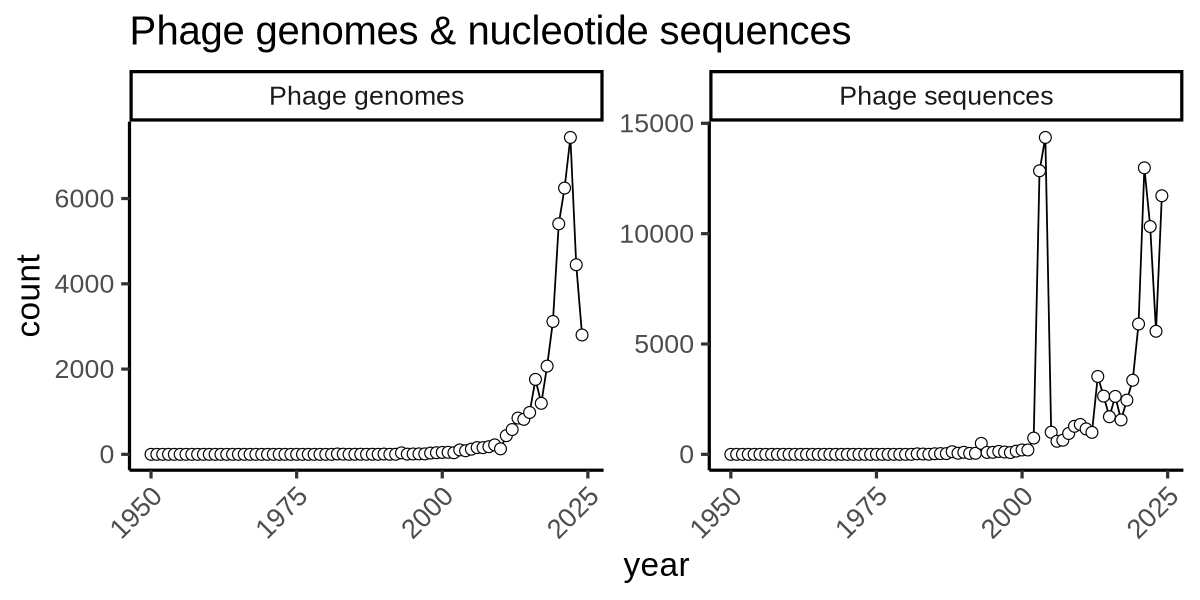

In [9]:
# Visualization
options(repr.plot.width=10, repr.plot.height=5)

## Wrangle
df <- gather(data, "search", "count", -year)

## Set factor levels


## Plot
ggplot(df, aes(year, count)) +
    geom_line() +
    geom_point(shape = 21, size = 3, fill = "white") +
    facet_wrap(~search, scales = "free_y") +
    theme_classic(20) +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, vjust=1)
    ) +
    labs(title = "Phage genomes & nucleotide sequences")

In [10]:
# Mutate
df <- group_by(df, search) %>% mutate(sum=cumsum(count))

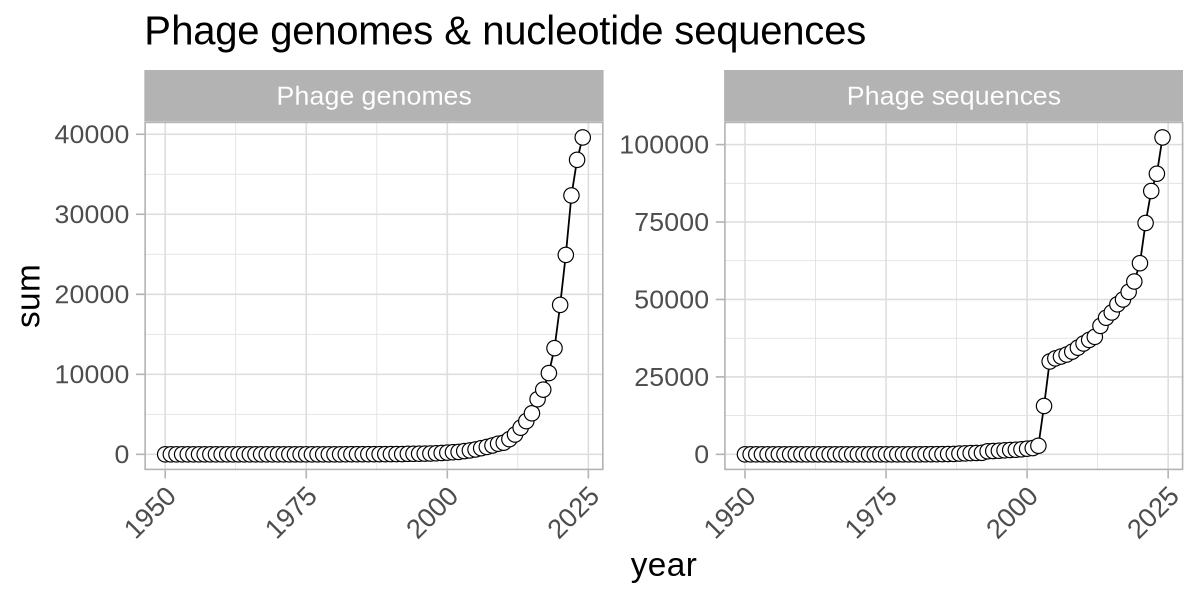

In [11]:
# Cumulative sum over years
options(repr.plot.width=10, repr.plot.height=5)

# Plot
ggplot(df, aes(year, sum)) +
    geom_line() +
    geom_point(shape = 21, size = 4, fill = "white") +
    facet_wrap(~search, scales = "free_y") +
    theme_light(20) +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, vjust=1)
    ) +
    labs(title = "Phage genomes & nucleotide sequences")

Warning message:
“Removed 50 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 100 rows containing missing values or values outside the scale range
(`geom_point()`).”


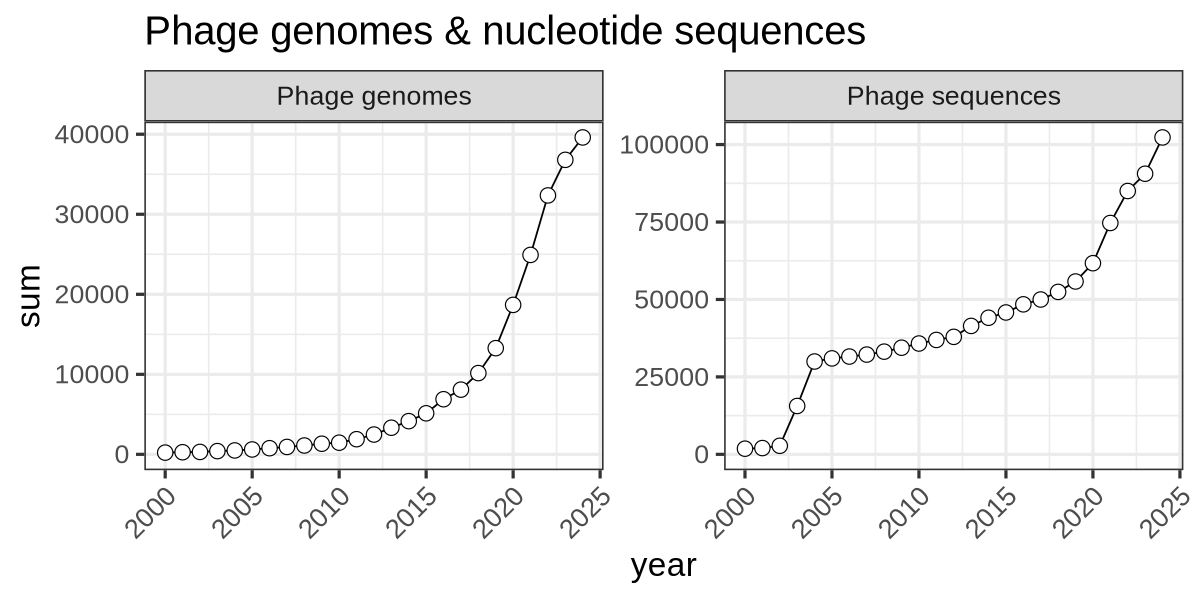

In [12]:
# Cumulative sum over years
options(repr.plot.width=10, repr.plot.height=5)

# Plot
ggplot(df, aes(year, sum)) +
    geom_line() +
    geom_point(shape = 21, size = 4, fill = "white") +
    facet_wrap(~search, scales = "free_y") +
    theme_bw(20) +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, vjust=1)
    ) +
        labs(title = "Phage genomes & nucleotide sequences") +
    scale_x_continuous(limits = c(2000, NA)) # Zoom

In [13]:
result <- entrez_search(db='nuccore', term=nucleotide_queries$`Phage genomes`, retmax=50000)
result

Entrez search result with 39602 hits (object contains 39602 IDs and no web_history object)
 Search term (as translated):  (phage[TITL] OR bacteriophage[TITL]) AND (genome[T ... 

In [14]:
## Convert entrez ID to nucleotide accession

query <- data.frame(
    entrez = result$ids
)

# Create groups of IDs
n_groups <- ceiling(result$count / 100)
query$group <- factor(sample(1:n_groups, nrow(query), replace=TRUE))

# Convert entrez to accession
query$accession <- NA
for (i in levels(query$group)) {
    ind <- which(query$group==i)
    # Accession
    x <- entrez_fetch(db='nuccore', id=query$entrez[ind], rettype='acc')
    query$accession[ind] <- head(str_split(x, "\\n")[[1]], -1)
}

## View
rbind(head(query,3), tail(query,3))

,entrez,group,accession
,<chr>,<fct>,<chr>
1,2868135305,319,PQ691273.1
2,2868134884,318,PQ678658.1
3,2868134552,105,PQ676539.1
39600,18496804,336,AF466696.1
39601,215623,13,M10145.1
39602,4096804,379,U40393.1


In [17]:
# Check IDs

## Unique
length(unique(query$entrez))
length(unique(query$accession))

## Overlap of query and selection
table(tables$phages$accession %in% query$accession)

[1] 39602

[1] 39602


TRUE 
  35 

In [18]:
# Check phages with annotated proteins
sel <- tables$proteins
sel$genome_accession <- NA
for (n in 1:nrow(sel)) {
    # Select ID
    i <- sel$protein_accession[[n]]

    # Error handling
    if (is.na(i)) {next}

    # Run ENTREZ query
    report <- try(entrez_fetch(db="protein", id=i, rettype = 'jsonl'))

    # Skip unknown sequences
    if (class(report) == 'try-error') {next}
    
    # Get NCBI protein report
    report <- str_split(report, '\n')[[1]] # Split into lines
    index <- which(str_detect(report, 'DBSOURCE')) # Detect which line (usually 5)
    db_source <- report[[index]]
    db_source <- str_split(db_source, '\\ ')[[1]]
    db_source <- db_source[[length(db_source)]] # Select last element
    sel$genome_accession[[n]] <- db_source
}

Error : HTTP failure: 400
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eEfetchResult PUBLIC "-//NLM//DTD efetch 20131226//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20131226/efetch.dtd">
<eFetchResult>
	<ERROR> Error: CEFetchPApplication::proxy_stream(): Error: F a i l e d  t o  u n d e r s t a n d  i d :  C W C 4 6 _ 0 9 1 0 5 &#xa;&#xa;</ERROR>
</eFetchResult>

Error : HTTP failure: 400
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eEfetchResult PUBLIC "-//NLM//DTD efetch 20131226//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20131226/efetch.dtd">
<eFetchResult>
	<ERROR> Error: CEFetchPApplication::proxy_stream(): Error: F a i l e d  t o  u n d e r s t a n d  i d :  C W C 4 6 _ 0 9 1 0 5 &#xa;&#xa;</ERROR>
</eFetchResult>



In [57]:
# Comparing accession numbers

## Check overlap
index <- sel$genome_accession %in% query$accession
table(index)

## Detect missing genomes
unique(sel$genome_accession[which(!index)])

## Manually add entries to query
entries <- list(
    data.frame(entrez='',group='manual',accession='OP946501.1'),
    data.frame(entrez='',group='manual',accession='OP946502.1'),
    data.frame(entrez='',group='manual',accession='OZ038340.1')    
)
entries <- bind_rows(entries)
query <- rbind(query, entries)

## Select unique accession numbers
query <- query[!duplicated(query$accession), ]

## View
rbind(head(query,3), tail(query,4))

index
FALSE  TRUE 
   16   207 

[1] NA           "CP056784.2" "OZ038340.1" "J01710.1"   "CP053607.1"
[6] "MW512264.1" "Y00148.1"   "M12742.1"

,entrez,group,accession
,<chr>,<fct>,<chr>
1,2868135305,319,PQ691273.1
2,2868134884,318,PQ678658.1
3,2868134552,105,PQ676539.1
39602,4096804,379,U40393.1
39603,,manual,OP946501.1
39604,,manual,OP946502.1
39607,,manual,OZ038340.1


In [58]:
# Add selection to query
query$core <- query$accession %in% tables$phages$accession
query$extended <- query$accession %in% sel$genome_accession

## View
rbind(head(query,3), tail(query,3))

,entrez,group,accession,core,extended
,<chr>,<fct>,<chr>,<lgl>,<lgl>
1,2868135305,319,PQ691273.1,FALSE,FALSE
2,2868134884,318,PQ678658.1,FALSE,FALSE
3,2868134552,105,PQ676539.1,FALSE,FALSE
39603,,manual,OP946501.1,FALSE,TRUE
39604,,manual,OP946502.1,FALSE,TRUE
39607,,manual,OZ038340.1,FALSE,TRUE


In [27]:
# Export accession numbers

## All phages
write.table(query, genomes$overview, sep = ',', quote = FALSE, row.names = FALSE)
writeLines(query$accession, genomes$all)

## Selection - core
writeLines(tables$phages$accession, genomes$core)

## Selection - extended
writeLines(sel$genome_accession, genomes$extended)

In [28]:
# Download selection

## Create call
call <- './bin/fetch_ncbi-genomes-by-accession.sh'
call <- paste(call, '-i', genomes$core)
call <- paste0(call, ' -o ', path, 'core_genomes')
call <- paste(call, '-e arabinosylation-anti-crispr')
call <- paste(call, '-t "virus genome"')
call

writeLines(call, 'tmp.sh')
system('bash tmp.sh', intern = TRUE)
system2(command = "bash", 
        args    = c("tmp.sh"), 
        stdout  = paste0("log/download_core-genomes_",Sys.Date(),".log"))
file.remove('tmp.sh')

[1] "./bin/fetch_ncbi-genomes-by-accession.sh -i data/ncbi_phage-genomes/core_genomes_accession.txt -o data/ncbi_phage-genomes/core_genomes -e arabinosylation-anti-crispr -t \"virus genome\""

[1] "-- Checking input arguments --"                                                               
 [2] "Getting accession numbers from data/ncbi_phage-genomes/core_genomes_accession.txt"            
 [3] "Output directory: data/ncbi_phage-genomes/core_genomes"                                       
 [4] "Query type: virus genome"                                                                     
 [5] "Activating arabinosylation-anti-crispr"                                                       
 [6] ""                                                                                             
 [7] "-- Checking for installed programs --"                                                        
 [8] "datasets: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin/datasets"            
 [9] "unzip: /usr/bin/unzip"                                                                        
[10] "dataformat: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin/dataformat"        
[11] ""                                                                                             
[12] "rtis-hpc-r04.uod.otago.ac.nz"                                                                 
[13] "Fri Dec 20 13:03:31 NZDT 2024"                                                                
[14] "Archive:  data/ncbi_phage-genomes/core_genomes.zip"                                           
[15] "  inflating: data/ncbi_phage-genomes/core_genomes/README.md  "                                
[16] "  inflating: data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/data_report.jsonl  "      
[17] "  inflating: data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/annotation_report.jsonl  "
[18] "  inflating: data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/biosample_report.jsonl  " 
[19] "  inflating: data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/cds.fna  "                
[20] "  inflating: data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/genomic.fna  "            
[21] "  inflating: data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/protein.faa  "            
[22] "  inflating: data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/virus_dataset.md  "       
[23] "  inflating: data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/dataset_catalog.json  "   
[24] "  inflating: data/ncbi_phage-genomes/core_genomes/md5sum.txt  "

[1] TRUE

In [59]:
# Download selection

## Create call
call <- './bin/fetch_ncbi-genomes-by-accession.sh'
call <- paste(call, '-i', genomes$extended)
call <- paste0(call, ' -o ', path, 'extended_genomes')
call <- paste(call, '-e arabinosylation-anti-crispr')
call <- paste(call, '-t "virus genome"')
call

writeLines(call, 'tmp.sh')
system('bash tmp.sh', intern = TRUE)
system2(command = "bash", 
        args    = c("tmp.sh"), 
        stdout  = paste0("log/download_extended-genomes_",Sys.Date(),".log"))
file.remove('tmp.sh')

[1] "./bin/fetch_ncbi-genomes-by-accession.sh -i data/ncbi_phage-genomes/ext_genomes_accession.txt -o data/ncbi_phage-genomes/extended_genomes -e arabinosylation-anti-crispr -t \"virus genome\""

[1] "-- Checking input arguments --"                                                                   
 [2] "Getting accession numbers from data/ncbi_phage-genomes/ext_genomes_accession.txt"                 
 [3] "Output directory: data/ncbi_phage-genomes/extended_genomes"                                       
 [4] "Query type: virus genome"                                                                         
 [5] "Activating arabinosylation-anti-crispr"                                                           
 [6] ""                                                                                                 
 [7] "-- Checking for installed programs --"                                                            
 [8] "datasets: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin/datasets"                
 [9] "unzip: /usr/bin/unzip"                                                                            
[10] "dataformat: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin/dataformat"            
[11] ""                                                                                                 
[12] "rtis-hpc-r04.uod.otago.ac.nz"                                                                     
[13] "Fri Dec 20 13:29:48 NZDT 2024"                                                                    
[14] "Archive:  data/ncbi_phage-genomes/extended_genomes.zip"                                           
[15] "  inflating: data/ncbi_phage-genomes/extended_genomes/README.md  "                                
[16] "  inflating: data/ncbi_phage-genomes/extended_genomes/ncbi_dataset/data/data_report.jsonl  "      
[17] "  inflating: data/ncbi_phage-genomes/extended_genomes/ncbi_dataset/data/annotation_report.jsonl  "
[18] "  inflating: data/ncbi_phage-genomes/extended_genomes/ncbi_dataset/data/biosample_report.jsonl  " 
[19] "  inflating: data/ncbi_phage-genomes/extended_genomes/ncbi_dataset/data/cds.fna  "                
[20] "  inflating: data/ncbi_phage-genomes/extended_genomes/ncbi_dataset/data/genomic.fna  "            
[21] "  inflating: data/ncbi_phage-genomes/extended_genomes/ncbi_dataset/data/protein.faa  "            
[22] "  inflating: data/ncbi_phage-genomes/extended_genomes/ncbi_dataset/data/virus_dataset.md  "       
[23] "  inflating: data/ncbi_phage-genomes/extended_genomes/ncbi_dataset/data/dataset_catalog.json  "   
[24] "  inflating: data/ncbi_phage-genomes/extended_genomes/md5sum.txt  "

[1] TRUE

In [30]:
# Download all genomes

## Create call
call <- './bin/fetch_ncbi-genomes-by-accession.sh'
call <- paste(call, '-i', genomes$all)
call <- paste0(call, ' -o ', path, 'all_genomes')
call <- paste(call, '-e arabinosylation-anti-crispr')
call <- paste(call, '-t "virus genome"')
call

writeLines(call, 'tmp.sh')
system2(command = "bash", 
        args    = c("tmp.sh"), 
        stdout  = paste0("log/download_all-genomes_",Sys.Date(),".log"))
file.remove('tmp.sh')

[1] "./bin/fetch_ncbi-genomes-by-accession.sh -i data/ncbi_phage-genomes/all_genomes_accession.txt -o data/ncbi_phage-genomes/all_genomes -e arabinosylation-anti-crispr -t \"virus genome\""

[1] TRUE

In [83]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.5.1 tidyr_1.3.1   dplyr_1.1.4   rentrez_1.2.3 stringr_1.5.1

loaded via a namespace (and not attached):
 [1] gtable_0.3.6      jsonlite_1.8.9    compiler_4.3.3    crayon_1.5.3     
 [5] tidyselect_1.2.1  IRdisplay_1.1     scales_1.3.0      uuid_1.2-1 